In [1]:
import os
import glob
import warnings
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

# `MERFISH`

Note: `ScaleFlow` is the old name for `Glimmer`

In [2]:
# Set common path and parameters
main_path = '/data/qiyu/spatialRegion/'
fig_path = main_path + 'figures/SVG/'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans'
path = main_path + "benchmark/results/"
merfish_data = main_path + "benchmark/Public_data/MERFISH/"
model = ["ScaleFlow", "GraphST", "SPIN", "SpaceFlow", "SCANIT"]
data_names = ["0", "1", "2", "3", "4"]
data_type = 'merfish'
seed = [1, 2, 3, 4, 5]
load_embedding = False
leiden_clustering = False 

### 1. Load embedding from MERFISH runs

In [3]:
def load_merfish_data(num, path):
    data_path = path
    data_ids = ["MERFISH_0.04_20241109014506.h5ad",
                "MERFISH_0.14_20241109015203.h5ad",
                "MERFISH_0.24_20241109015212.h5ad",
                "MERFISH_0.09_20241109014907.h5ad",  
                "MERFISH_0.19_20241109015208.h5ad"]
    adata = sc.read_h5ad(data_path + data_ids[int(num)])
    return adata

if load_embedding:
    for data in data_names:
        # save all embeddings to adata
        save_file = f"{path}/{data_type}/{data}/all_res.h5ad"
        if os.path.exists(save_file):
            adata = ad.read(save_file)
        else:
            adata = load_merfish_data(data, merfish_data)

        # load embeddings
        file_list = []
        for m in model:
            dir_path = os.path.join(path, data_type, data, m)
            if os.path.exists(dir_path):
                file_list.extend([os.path.join(dir_path, f) for f in os.listdir(dir_path) if not f.endswith("run_times.txt")])
        for item in file_list:
            emb_name, _ = os.path.splitext(os.path.basename(item))
            print(f"Loading {emb_name} for data{data}")
            adata.obsm[emb_name] = np.genfromtxt(item, delimiter=',', dtype=float)
            adata.write(save_file)

### 2. Leiden clustering on the embedding

In [4]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score

def compute_metrics(adata, ground_truth, pred_key):
    return {
        "NMI": normalized_mutual_info_score(adata.obs[ground_truth], adata.obs[pred_key]),
        "ARI": adjusted_rand_score(adata.obs[ground_truth], adata.obs[pred_key]),
        "Homogeneity": homogeneity_score(adata.obs[ground_truth], adata.obs[pred_key]),
        "Completeness": completeness_score(adata.obs[ground_truth], adata.obs[pred_key])
    }

def save_results(data, results, path, data_type, model):
    for metric, result_list in results.items():
        metric_df = pd.DataFrame(result_list, columns=['data_num', 'Embedding', 'Value', 'Cluster Number', 'Resolution'])
        metric_df['Model'] = metric_df['Embedding'].str.split('_').str[0].replace('Our', 'ScaleFlow')
        metric_df.to_csv(f"{path}/{data_type}/{data}/{data}_{metric.lower()}_{model}.csv", index=False)

# Main processing loop
res_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
if leiden_clustering:
    for data in data_names:
        for m in model:
            m = "Our" if m == "ScaleFlow" else m
            adata = sc.read(f"{path}/{data_type}/{data}/all_res.h5ad")
            print(f"\nProcessing data index {data}")

            all_results = {metric: [] for metric in ["NMI", "ARI", "Homogeneity", "Completeness"]}
            for emb in filter(lambda x: x.startswith(m), adata.obsm.keys()):
                print(f"\nRunning {emb} for data {data}")
                for res in res_list:
                    sc.pp.neighbors(adata, use_rep=emb, random_state=42, n_pcs=adata.obsm[emb].shape[1])
                    sc.tl.leiden(adata, resolution=res, random_state=42)
                    cluster_number = len(adata.obs['leiden'].unique())
                    print(f"Resolution: {res}, Number of clusters: {cluster_number}")
                    metrics = compute_metrics(adata, "ground_truth", "leiden")
                    for metric, value in metrics.items():
                        all_results[metric].append([data, emb, value, cluster_number, res])

            save_results(data, all_results, path, data_type, m)

### 3. Load results from MERFISH runs

In [5]:
save_file_name = f"{path}/MERFISH_combined_scores.csv"

if os.path.exists(save_file_name):
    all_df = pd.read_csv(save_file_name)
else:
    all_data = []
    for n in data_names: 
        metrics = {
            "nmi": "NMI",
            "ari": "ARI",
            "homogeneity": "Homogeneity",
            "completeness": "Completeness"
        }
        dfs = [ 
            pd.concat([pd.read_csv(file) for file in glob.glob(f"{path}/{data_type}/{n}/*{key}*.csv")], ignore_index=True)
            .assign(Metric=value)
            for key, value in metrics.items()
        ]
        df = pd.concat(dfs, ignore_index=True)
        wd_size = 3
        df = df[df['Cluster Number'].isin(range(8 - wd_size, 8 + wd_size))]
        df = df.groupby(['data_num', 'Embedding', 'Model', 'Metric', 'Cluster Number'])['Value'].mean().reset_index()
        all_data.append(df)
    all_df = pd.concat(all_data, ignore_index=True)
    all_df.to_csv(save_file_name, index=False)

### 4. Visualize the results

In [6]:
seed_select = 2
data = '3'
rep_list = ['Our', 'SPIN', 'SCANIT', 'SpaceFlow', 'GraphST', 'Banksy']
tittle_list = ['ScaleFlow', 'SPIN', 'SCANIT', 'SpaceFlow', 'GraphST', 'Banksy']

save_file = f"{path}/{data_type}/{data}/all_res.h5ad"
adata = ad.read(save_file)
for m in rep_list:
    print(f"Running {m} for data {data}")
    use_rep = f"{m}_emb_seed{seed_select}"
    sc.pp.neighbors(adata, use_rep=use_rep, random_state=42, n_neighbors=20)
    sc.tl.louvain(adata, resolution=0.5, random_state=42, key_added=f'{m}_leiden')
    sc.tl.umap(adata, random_state=42)
    adata.obsm[f'{m}_umap'] = adata.obsm['X_umap']

Running Our for data 3
Running SPIN for data 3
Running SCANIT for data 3
Running SpaceFlow for data 3
Running GraphST for data 3
Running Banksy for data 3


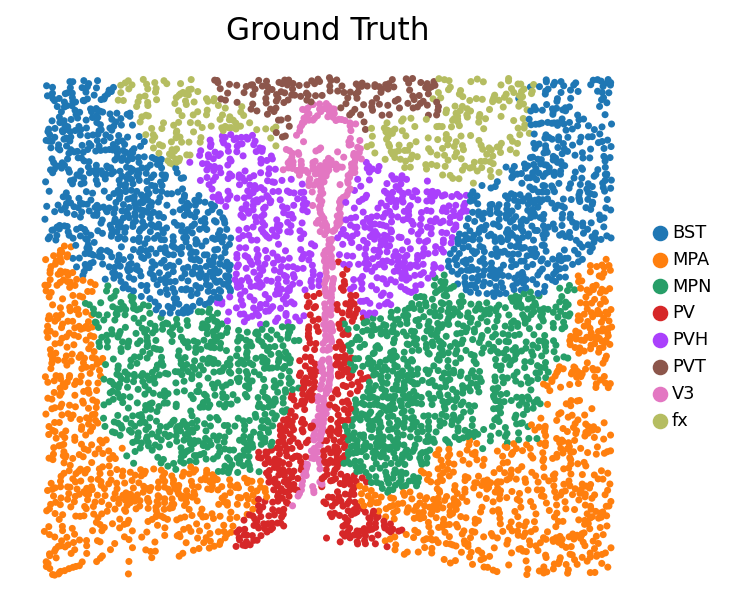

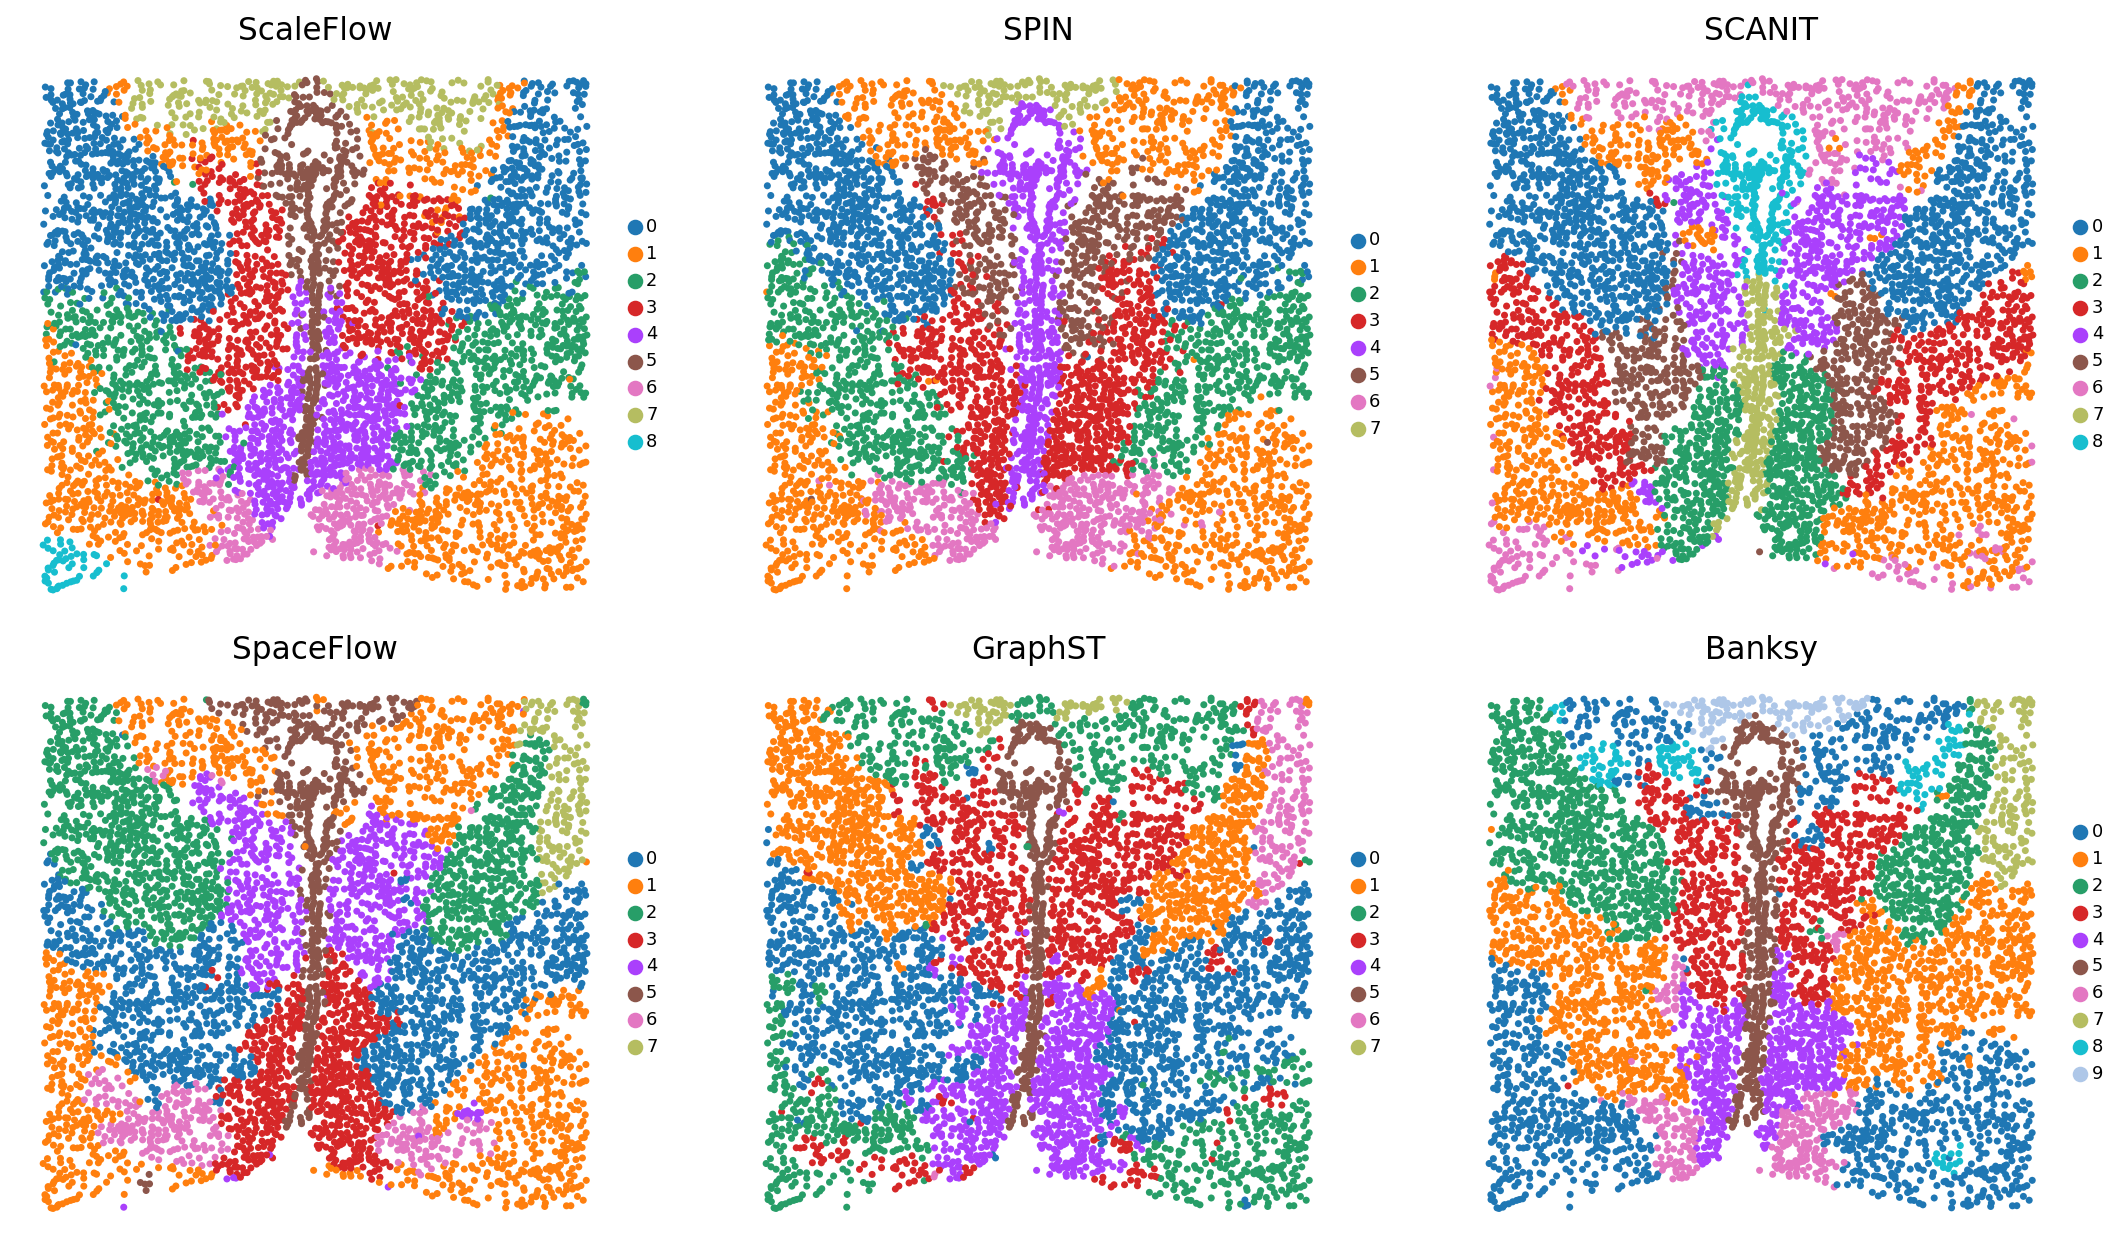

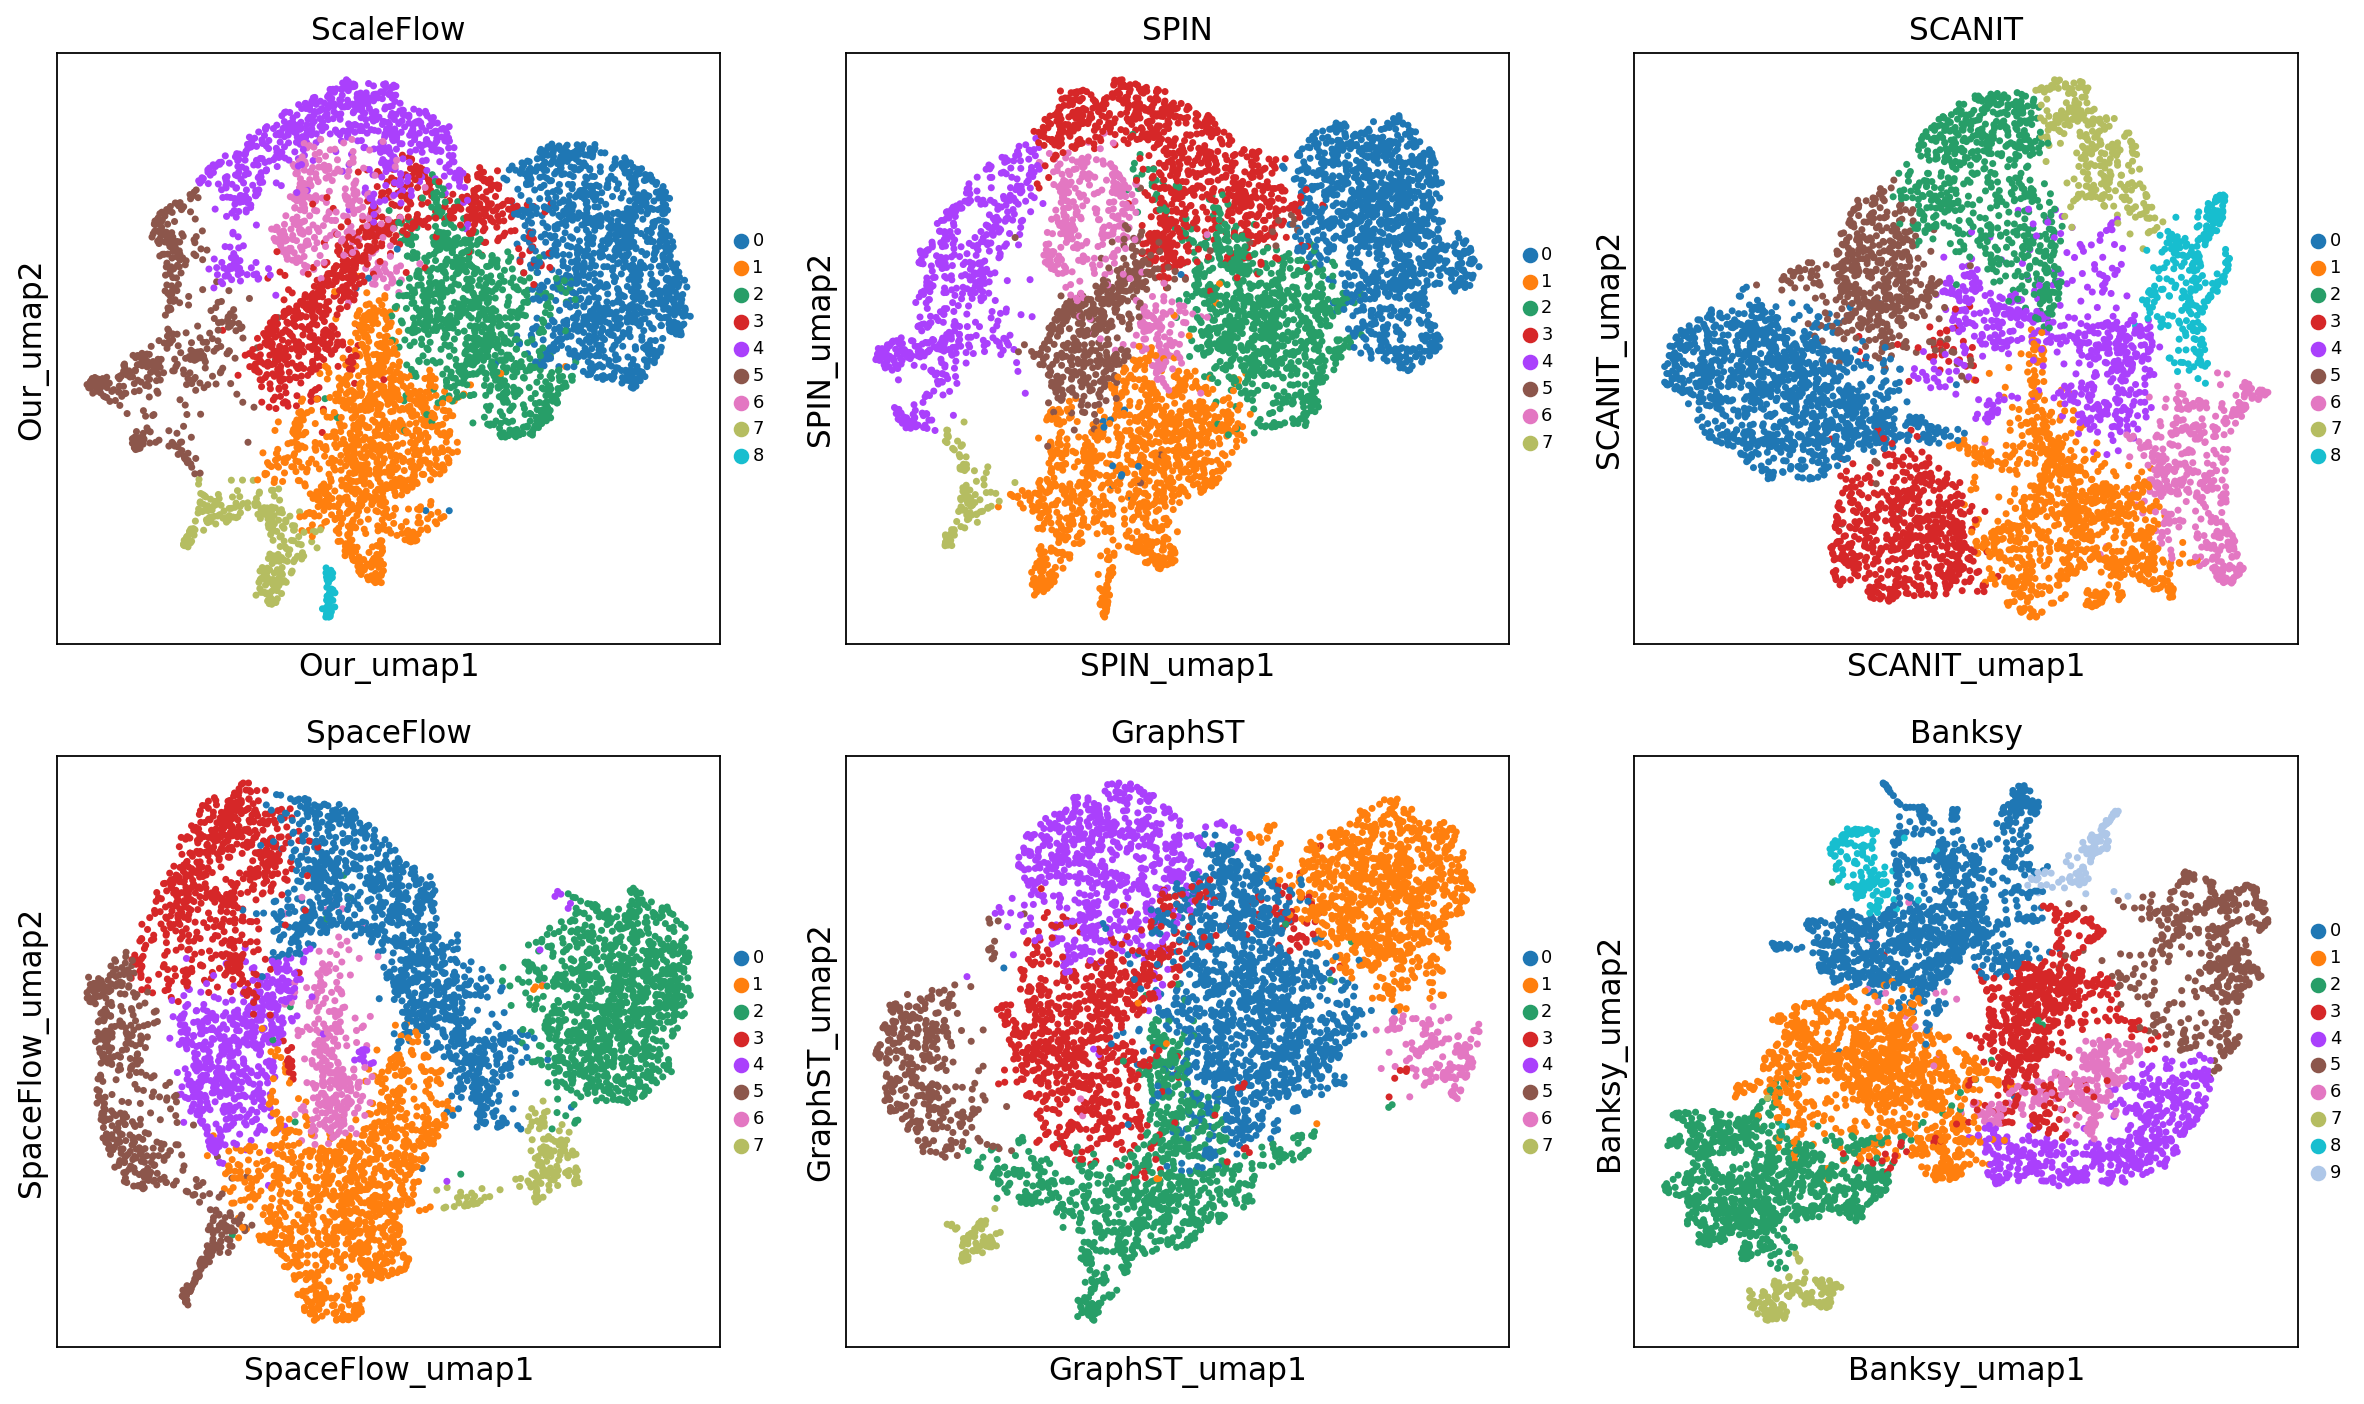

In [7]:
# spatial plot
save_fig = True
fig_base_path = fig_path + 'figure3/'
fig_names = [
    fig_base_path + 'fig3_m_merfish_mouse_brain_ground_truth.svg',
    fig_base_path + 'fig3_m_merfish_mouse_brain_spatial_leiden.svg',
    fig_base_path + 'fig3_s_merfish_mouse_brain_umap_leiden.svg',
]

sc.settings.set_figure_params(figsize=(5, 4.5))
# Ground Truth (spatial)
fig1 = sc.pl.embedding(
    adata,
    basis='spatial',
    ncols=3,
    cmap='tab20',
    size=40,
    legend_fontsize=8,
    color='ground_truth',
    title='Ground Truth',
    frameon=False,
    wspace=0.1,
    hspace=0.1,
    show=False,
    return_fig=True
)
fig1.savefig(fig_names[0], format="svg", bbox_inches="tight")

# Leiden (spatial)
fig2 = sc.pl.embedding(
    adata,
    basis='spatial',
    ncols=3,
    cmap='tab20',
    size=40,
    legend_fontsize=8,
    color=[f'{m}_leiden' for m in rep_list],
    title=tittle_list,
    frameon=False,
    wspace=0.1,
    hspace=0.1,
    show=False,
    return_fig=True
)
if save_fig:
    fig2.savefig(fig_names[1], format="svg", bbox_inches="tight")

# Leiden (UMAP)
sc.settings.set_figure_params(figsize=(5, 4))
ncols = 3
nrows = (len(rep_list) // ncols) + (len(rep_list) % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4.5 * nrows))
axes = axes.flatten()
for i, m in enumerate(rep_list):
    if f'{m}_umap' in adata.obsm and f'{m}_leiden' in adata.obs:
        sc.pl.embedding(adata, basis=f'{m}_umap', cmap='tab20', size=40, 
                        legend_fontsize=8, color=f'{m}_leiden', 
                        title=tittle_list[i], show=False, ax=axes[i])
    else:
        axes[i].axis("off")
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
if save_fig:
    fig.savefig(fig_names[2], format="svg", bbox_inches="tight")
plt.show()